# Data for Statistical Downscaling and BCSD
### Yi Li

- Last time
    - play with the data
    - study basic statistical downscaling method
- 1 Data 
    - GCM (simulation): coarser scale
    - Observation: finer scale
- 2 Statistical Downscaling Model
    - BCSD: Bias correction and spatial disaggregation 
    - (Nonparametric) Copula modified BCSD
- 3 Example
    - Precipitation
    - Columbia River Basin 
- Note
    - I will show **EVERY** steps in detail
    - Please feel free to correct me and provide any suggestion

# GCM Data

- GCM (Global Climate Model): expensive, computationally expensive, no sigle unit or country can do this
- WCRP (World Climate Research Programme) initiate the CMIP (Coupled Model Intercomparison Project)
- Now it is CMIP5 (phase 5)
- It provide results for IPCC (Intergovernmental Panel on Climate Change) Assessment Report
- Will use the CMIP5 **[GFDL-CM3](http://www.gfdl.noaa.gov/coupled-physical-model-cm3)** Model
- GFDL (Geophysical Fluid Dynamics Laboratory) at Princeton, mission
    - Advance scientific understanding of climate and its natural and anthropogenic variations and impacts
    - Improve NOAA's predictive capabilities, through the development and use of world-leading computer models of the Earth System



# Observation Data

- [University of Idaho Gridded Surface Meteorological Data](http://metdata.northwestknowledge.net/)
- Spatial Resolution: 4-km (1/24-degree) grid
- Spatial Extent: Coterminous United States
- Temporal Resolution: Daily (some sub-daily)
- Temporal Extent: 1979-present (1-2 day lag)
- Variables: (all variables are daily extrema/sums/means over a given calendar day)
    - Precipitation
    - Temperature (maximum and minimum)
    - Humidity (maximum and minimum relative humidity and specific humidity)
    - Surface downward shortwave radiation (daily mean)
    - 10-meter Wind velocity (daily mean)
    - Reference evapotranspiration
    - NFDRS fire danger indices
- Format: netCDF adhering to Climate and Forecasting Metadata standards 

# BCSD

- Bias correction and spatial disaggregation 
    - 1. Quantile Mapping (QM): corrects bias in GCM
    - 2. Local scaling to downscale the data
- Copula modification
    - In the first (QM) part 
    - Using conditional distribution instead
    - An Improved Statistical Downscaling Method Based on Copula and Its Application, by Yueyue Qin
    - Climate Change Assessment in Columbia River Basin (CRB) Using Copula Based on Coupling of Temperature and Precipitation, by Yueyue Qin


# Example Data: Columbia River 

- One GCM grid: (-116.25W,45N),(-116.25W,43N),(-113.75W,43N),(-113.75W,45N)
- GCM data:
    - GFDL-CM3 
    - Precipitaiton
    - 2.5*2.5 (300km*250km)
    - Daily
- Observation data:
    - University of Idaho
    - 4km*4km grid (the US)
    - 1979 - 2003, Daily 
    - netCDF
- Work on Month by Month
    - January: example of wet season
    - July: example of dry season

# Step 1. Load the GCM data

In [1]:
# ipython nbconvert script.ipynb --to slides --post serve
source('functions.R')
MON=1:365
names(MON)=c(rep("JAN",31),rep("FEB",28),rep("MAR",31),rep("APR",30),rep("MAY",31),rep("JUN",30),
             rep("JUL",31),rep("AUG",31),rep("SEP",30),rep("OCT",31),rep("NOV",30),rep("DEC",31))
Mon=data.frame(mon=as.character(unique(names(MON))),num=1:12,days=c(31,28,31,30,31,30,31,31,30,31,30,31))
################## 1. Read in the GCM data(train) ##################
mylon=c(-116.25,-113.75)
mylat=c(43,45)
mon=1 # Month number: Jan=1
# 1.1 training
# http://nomads.gfdl.noaa.gov:8080/DataPortal/cmip5.jsp RCP6 & historical 
# X1=get_gcm(-113.75+180,43); X2=get_gcm(-113.75+180,45); X3=get_gcm(-116.25+180,45); 
X=get_gcm_train(mylon[1]+180,mylat[1]) # X=(X1+X2+X3+X4)/4 # kg/m^2/s = mm/hr *3600
colnames(X)=1975:2005; rownames(X)=1:365 # rm(X1,X2,X3,X4)
X=X[,5:29] * 3600 * 24 # mm # 365 days * 25 years # http://weather.unisys.com/wxp/wxp5/Users/units.lup

# 1.2 testing
X_test=get_gcm_test(mylon[1]+180,mylat[1])
colnames(X_test)=2006:2015; rownames(X_test)=1:365
X_test=X_test * 3600 * 24

In position:  63.75 43 
Read in file  pr_day_GFDL-CM3_historical_r1i1p1_19750101-19791231.nc 
Read in file  pr_day_GFDL-CM3_historical_r1i1p1_19800101-19841231.nc 
Read in file  pr_day_GFDL-CM3_historical_r1i1p1_19850101-19891231.nc 
Read in file  pr_day_GFDL-CM3_historical_r1i1p1_19900101-19941231.nc 
Read in file  pr_day_GFDL-CM3_historical_r1i1p1_19950101-19991231.nc 
Read in file  pr_day_GFDL-CM3_historical_r1i1p1_20000101-20041231.nc 
Read in file  pr_day_GFDL-CM3_historical_r1i1p1_20050101-20051231.nc 
In position:  63.75 43 
Read in file  pr_day_GFDL-CM3_rcp60_r1i1p1_20060101-20101231.nc 
Read in file  pr_day_GFDL-CM3_rcp60_r1i1p1_20110101-20151231.nc 


# Step 2. Load the Observation data

In [2]:
################## 2. Read in the observation data(train) ##################
ncin = nc_open(paste0("./obs_in_grid/","obs_in_grid_",mylon[1],"-",mylat[1],".nc"))
lon = ncvar_get(ncin,"longitude")
lat = ncvar_get(ncin,"latitude")
t1=ncvar_get(ncin,"time")
Pr=ncvar_get(ncin,"precipitation") # 60*48*[365*37]  
# 2.1 testing
t1_test=t1[-(1:(365*27))]
Pr_test=Pr[,,-(1:(365*27))]
# 2.2 training
t1=t1[1:(365*25)]
Pr=Pr[,,1:(365*25)]

In [3]:
############# Month-specific Data Manipulation ############# 
# GCM
Xi=X[MON[names(MON)==Mon[mon,1]],] # 31 days * 25 years
Xim=apply(Xi,2,sum) # 1 month * 25 years 
# OBS
Pr1=Pr[,,is.element(t1,MON[names(MON)==Mon[mon,1]])]
Yi=matrix(apply(Pr1,3,mean),Mon[mon,3],25); colnames(Yi)=1979:2003
Yim=apply(Yi,2,sum) 


Xi_test=X_test[MON[names(MON)==Mon[mon,1]],]
Xim_test=apply(Xi_test,2,sum)

Pr1_test=Pr_test[,,is.element(t1_test,MON[names(MON)==Mon[mon,1]])]
Yi_test=matrix(apply(Pr1_test,3,mean),Mon[mon,3],10); colnames(Yi_test)=2006:2015
Yim_test=apply(Yi_test,2,sum) 


# Y=read.csv("obs_avg.csv",header = F); Y=t(Y); colnames(Y)=1979:2003; rownames(Y)=1:365
# Yi=Y[MON[names(MON)=="JAN"],] # 31 days * 25 years
# Yim=apply(Yi,2,sum) # 1 month * 25 years 

In [4]:
print(Xim)
print("=====================")
print(Yim)
print("=====================")
print(Xim_test)

      1979       1980       1981       1982       1983       1984       1985 
 9.7914598  0.7951854 12.4595052 34.1951087  8.6849366 13.7170828  6.1701658 
      1986       1987       1988       1989       1990       1991       1992 
13.8710300 21.4132170 40.4770558  5.6355218  5.6061121 10.7725976 25.1064211 
      1993       1994       1995       1996       1997       1998       1999 
11.0897956  4.2589990  9.4311149  1.3522785 13.9735028  9.4840724 15.4634588 
      2000       2001       2002       2003 
11.4293786 12.6426780 10.0966838 17.0593963 
[1] "====================="
      1979       1980       1981       1982       1983       1984       1985 
 55.329821 129.974292  56.766120  68.983241  71.370182   8.058007  13.200932 
      1986       1987       1988       1989       1990       1991       1992 
 37.386211  36.297026  48.369985  19.422116  38.412004   6.872329  11.842619 
      1993       1994       1995       1996       1997       1998       1999 
108.512940  12.440679 13

# Step 3: Empirical CDF used for Quantile Mapping

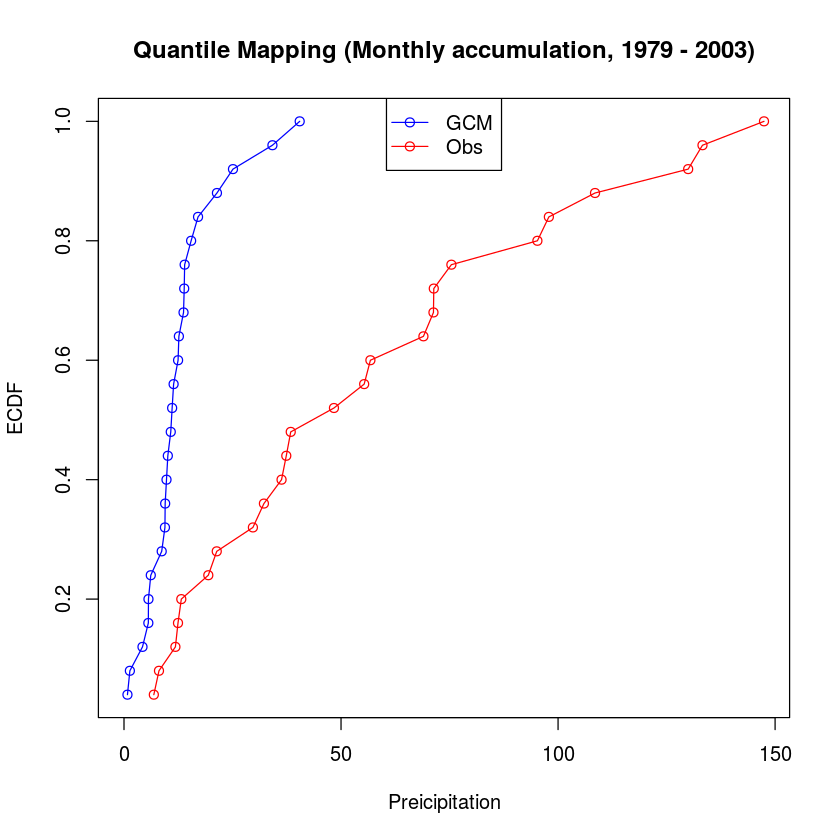

In [5]:
plot(sort(Xim),rank(sort(Xim))/length(Xim),type="o",xlim=c(0,max(Yim)),xlab="Preicipitation",ylab="ECDF",
     main="Quantile Mapping (Monthly accumulation, 1979 - 2003)",col="blue")
lines(sort(Yim),rank(sort(Yim))/length(Yim),type="o",col="red")
legend("top",c("GCM","Obs"),lty=1,pch=1,col=c("blue","red"))

# Step 4: Quantile Mapping

In [6]:
################## Quantile Mapping ##################
# training
Qi=quantile(Yim,ecdf(Xim)(Xim))
# testing
# Xim_test=Xim
Qi_test=quantile(Yim,ecdf(Xim)(Xim_test))

# Step 5: Copula Modification

Essentially: 

- Given Data
    - $X$: GCM
    - $Y$: Obs
- Task
    - provide GCM predict $x_t$
    - what is $y_t$, the correction?

$$y_t=argmax_{Obs}f(Obs|GCM)=argmax_{y}f(y|x_t)$$

So with copula $f(x,y)=c(u,v)f(x)f(y)$, $U=F_{GCM}(X)$, $V=F_{Obs}(Y)$, we have

$$y_t=argmax_{y}f(y|x_t)=argmax_{y}\frac{f(x_t,y)}{f(x_t)}=argmax_{y}c(u_t,v)f(y)$$

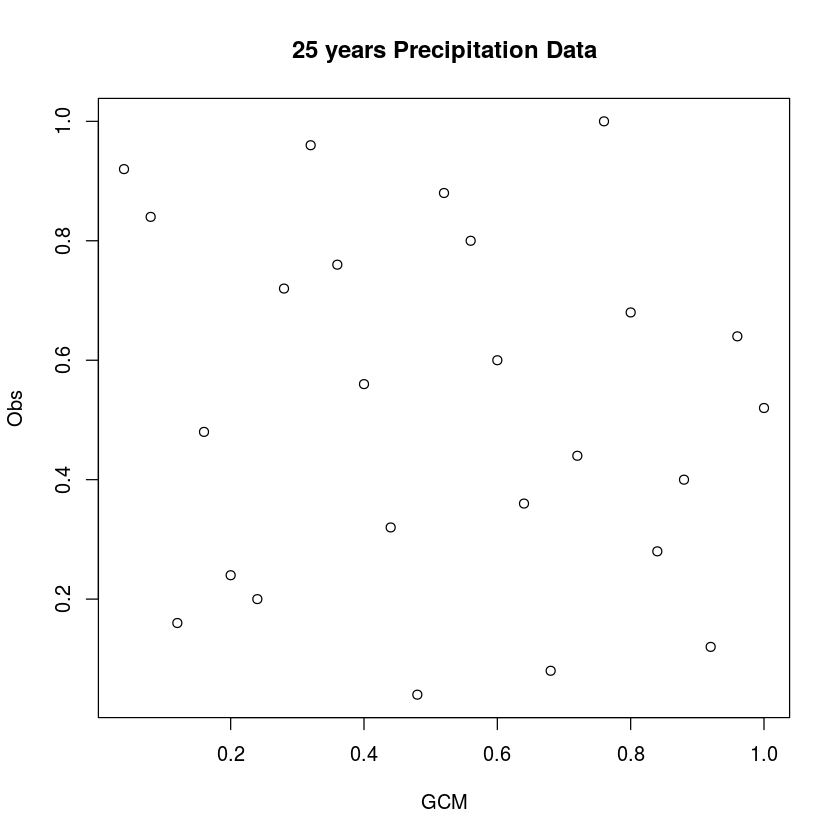

In [7]:
L=length(Xim)
plot(rank(Xim)/L,rank(Yim)/L,xlab="GCM",ylab="Obs",main="25 years Precipitation Data")

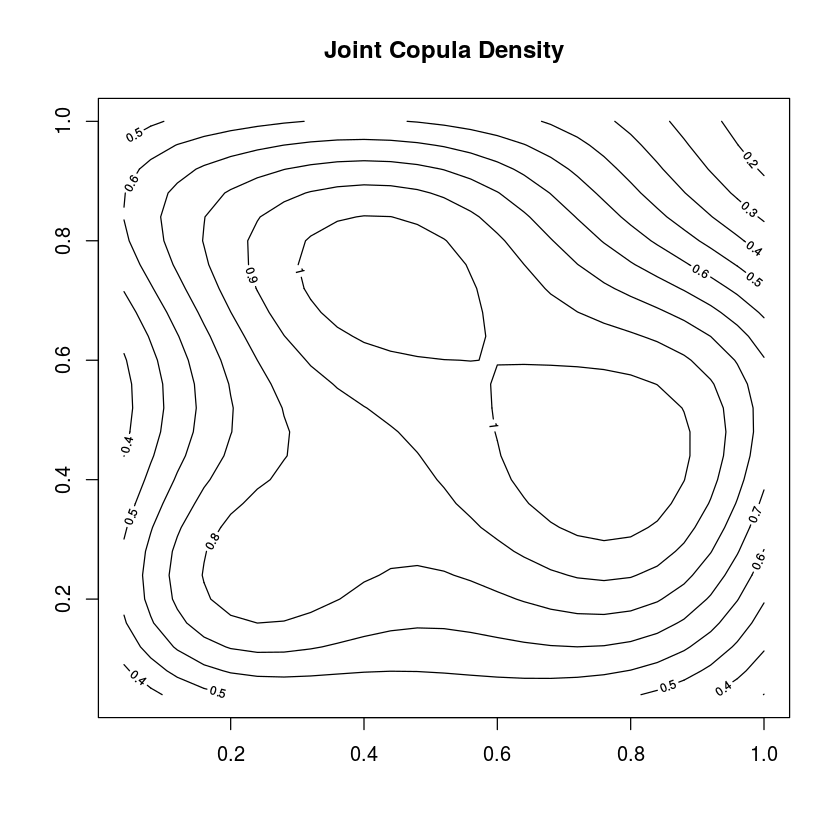

In [8]:
f=kde2d(rank(Xim)/L,rank(Yim)/L)
contour(f,main="Joint Copula Density")

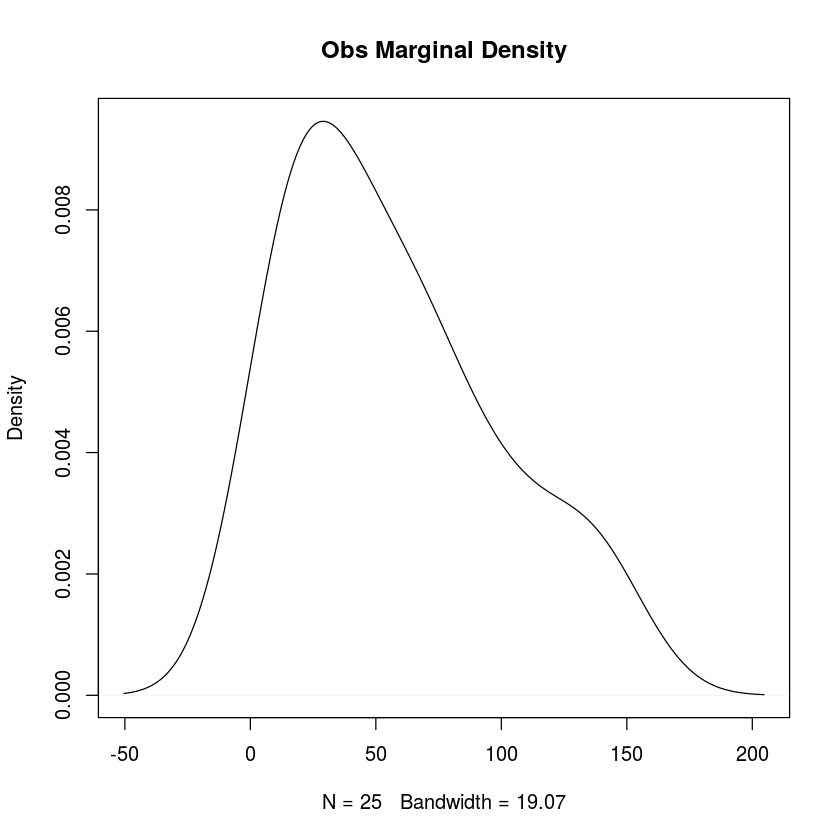

In [9]:
plot(density(Yim),main="Obs Marginal Density")

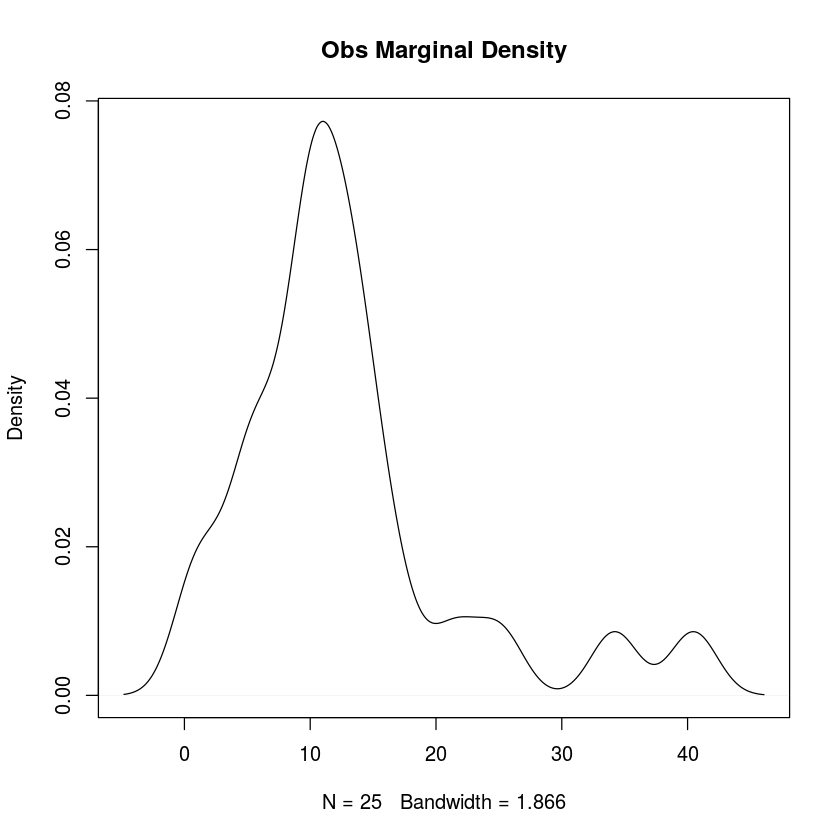

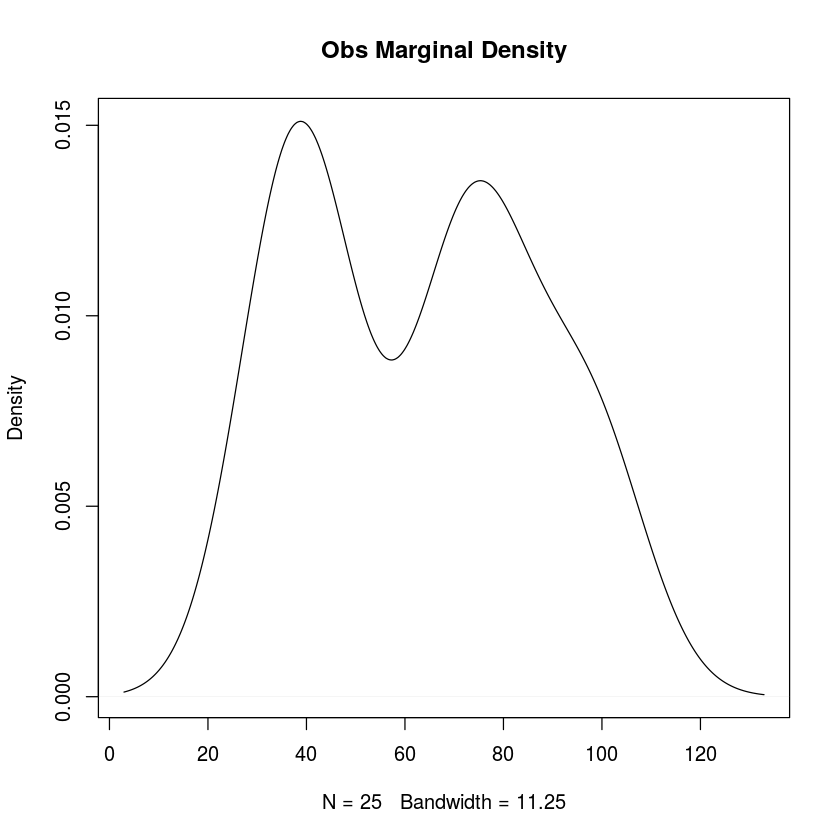

In [14]:
plot(density(Xim),main="Obs Marginal Density")
plot(density(Ci),main="Obs Marginal Density")

In [11]:
################## Copula ##################
Ci=Xim
for(i in 1:length(Xim)){
  Ci[i]=max_cond(Xim[i],Xim,Yim)
}
# testing
Ci_test=Xim_test
for(i in 1:length(Xim_test)){
  Ci_test[i]=max_cond(Xim_test[i],Xim,Yim)
}

# Step 6: Compare the Bias Correction Results

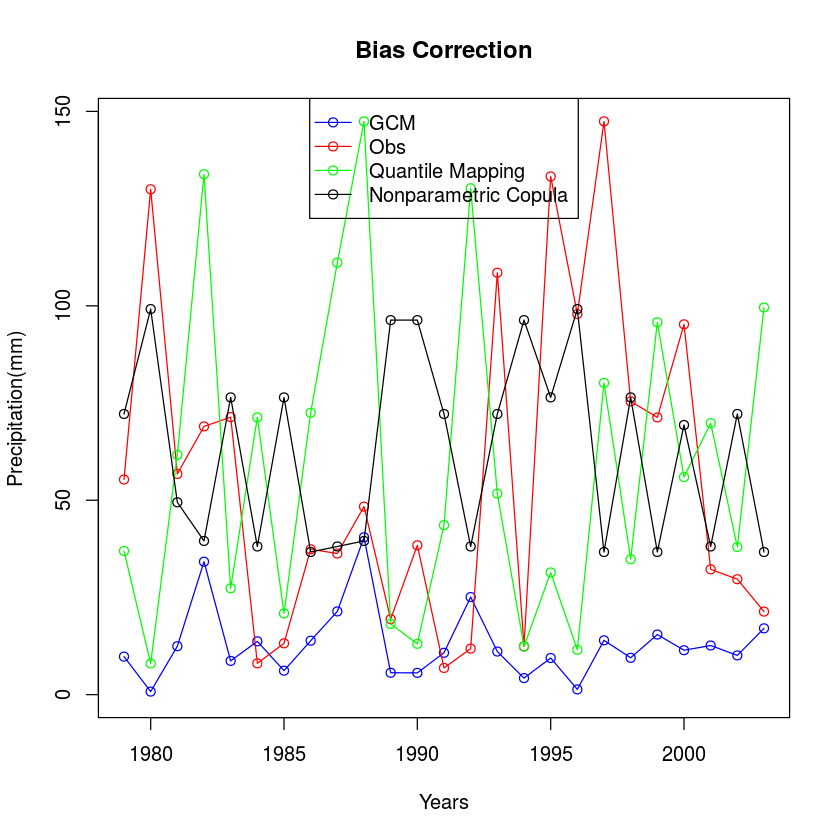

In [18]:
plot(1979:2003,Xim,type="o",ylim=c(0,max(Yim)),col="blue",xlab="Years",ylab="Precipitation(mm)",main="Bias Correction")
lines(1979:2003,Yim,type="o",col="red")
lines(1979:2003,Qi,type="o",col="green")
lines(1979:2003,Ci,type="o",col="black")
legend("top",c("GCM","Obs","Quantile Mapping","Nonparametric Copula"),lty=1,pch=1,col=c("blue","red","green","black"))

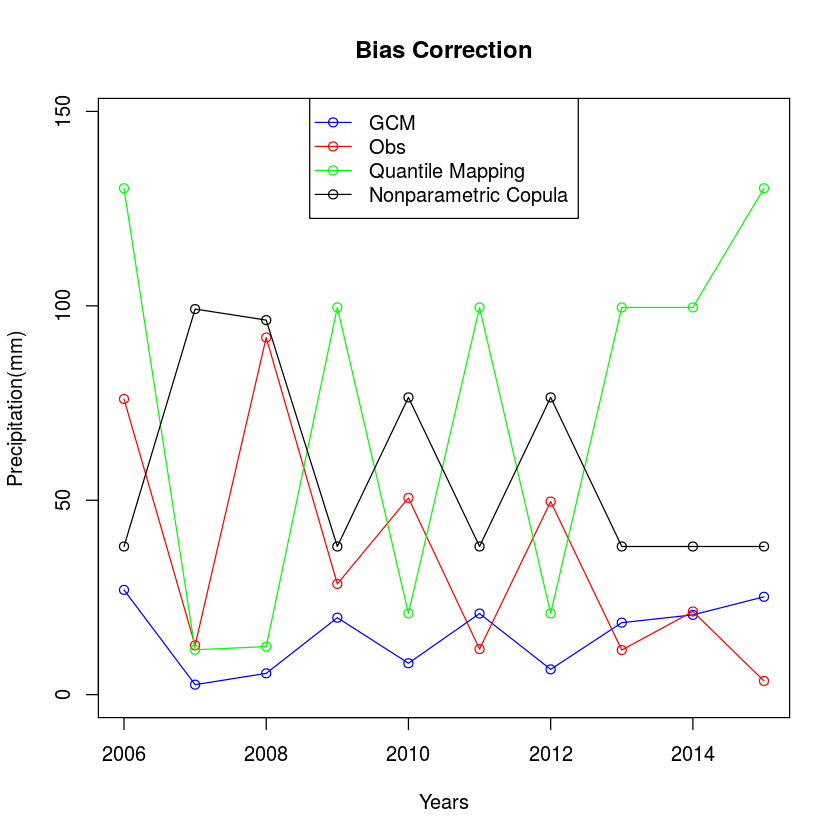

In [19]:
plot(2006:2015,Xim_test,type="o",ylim=c(0,max(Yim)),col="blue",xlab="Years",ylab="Precipitation(mm)",main="Bias Correction")
lines(2006:2015,Yim_test,type="o",col="red")
lines(2006:2015,Qi_test,type="o",col="green")
lines(2006:2015,Ci_test,type="o",col="black")
legend("top",c("GCM","Obs","Quantile Mapping","Nonparametric Copula"),lty=1,pch=1,col=c("blue","red","green","black"))

In [20]:
sqrt(mean((Yim-Qi)^2)) # Training RMSE for Quantile Mapping
sqrt(mean((Yim-Ci)^2)) # Training RMSE for Copula

sqrt(mean((Yim_test-Qi_test)^2)) # Testing RMSE for Quantile Mapping
sqrt(mean((Yim_test-Ci_test)^2)) # Testing RMSE for Copula

[1] 61.66357

[1] 44.35626

[1] 73.26002

[1] 36.46254

# Step 7: Spatial disaggregation

In [21]:
rmse1=rmse2=rmse3=rep(0,10)

for(k in 1:10){
  T1=apply(Pr1_test[,,(1:Mon[mon,3])+(k-1)*Mon[mon,3]],c(1,2),sum) # Test truth (not available in real case) (for a given year)
  
  M=apply(Pr1,c(1,2),sum)/25 # Local Historical Monthly (accumulation) mean
  D1=Ci_test[k]*M/mean(Ci) #Copula; Downscale 1979 Jan, actually apply to training data (which need to try in testing data)
  D2=Qi_test[k]*M/mean(Qi) #QM Downscale 1979 Jan, actually apply to training data (which need to try in testing data)
  D3=Xim_test[k]*M/mean(Xim) #GCM
  
  rmse1[k]=sqrt(mean((D1-T1)^2)) 
  rmse2[k]=sqrt(mean((D2-T1)^2)) 
  rmse3[k]=sqrt(mean((D3-T1)^2)) 
}


[1] 0.9

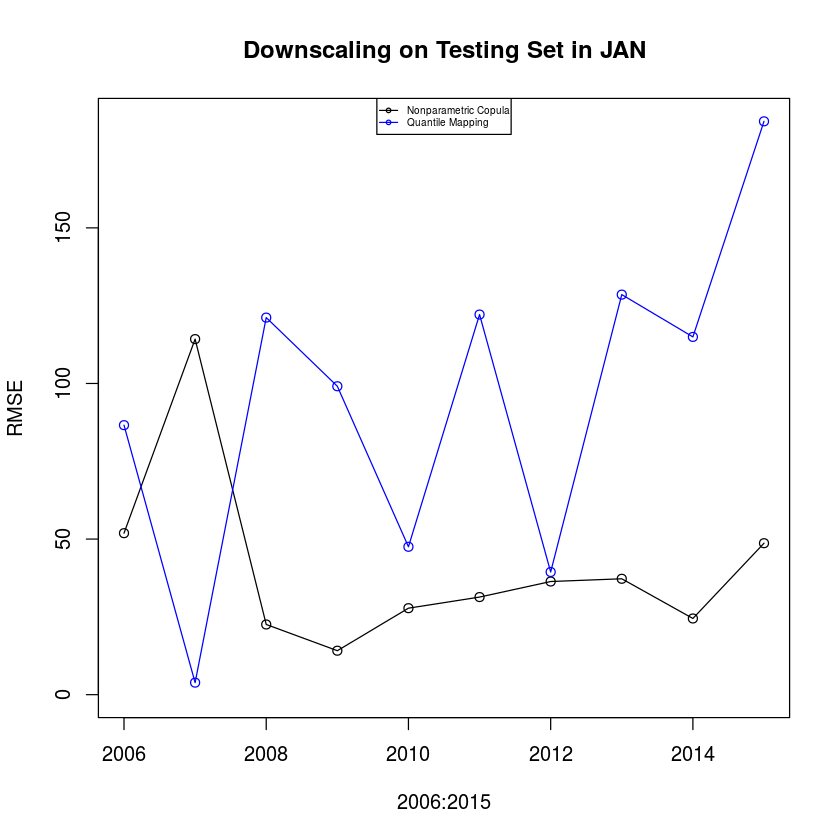

In [23]:
plot(2006:2015,rmse1,col="black",type="o",ylim = c(0,max(c(rmse1,rmse2,rmse3))),ylab="RMSE",
     main=paste("Downscaling on Testing Set in",Mon[mon,1]))
lines(2006:2015,rmse2,col="blue",type="o")
#lines(2006:2015,rmse3,col="red",type="o")
legend("top",c("Nonparametric Copula","Quantile Mapping"),lty=1,pch=1,col=c("black","blue"),cex=0.5)
mean(rmse1<rmse2)

# NEED help and discussion

- Computation
    - observation data is large (1.2G per variable per year), even though did it grid by grid currently
    - Storage: 1 variable 30 years = 30+G
    - Memory: when loading 1.2G data
        - 4G memory: R, Matlab, Python crashed
        - 8G memory: R use 6G memeory, Matlab 4~5G memory. When write a function to load the data, R crashes(even though I remove the object in the body of the function). So in the example, I did it with Matlab, and saved the result.
    - Current: I put the large data in my portable hard drive, and bought a new 8G memory cards
    - Future: 
         - From one grid to all the grid: load more data in memory? Parallelize it?
         - One grid is affected by other grids/other variables: need to load more data
    - Any other suggestion on dealing with large data / switch to another dataset (may have similar issue)
- Climate 
    - Am I using the right GCM model/data? 
    - Is it the current version of the data?
    - Even for fix GCM data, there are a lot of variations. Which one should I use?
    - Am I using the right local observation data?
    - Convert precipitation rate to precipitation in a day (kg/m^2/s = daily mm * 3600 * 24)
    - For a grid, use average of 4 corners or one fixed corner? 
    - How to deal with Feb. 29?
    - What variable is Cybersees interested in? Downscale the temprature?
- Method
    - Use neighbour grid to help bias correction?
    - Use other variables?
    - Use regression?
    - How to extend to extreme value?

# Possible Future Work

- Evaluation Method
- Apply it to the future GCM projection (without observation)
- Apply it to other grid
- Try using the grid in the center (currently used lower-left corner)
- Apply it to seasonal scale
- Apply it to temprature 
- Add reanalysis data
- Any other comments